## Task: Train an FashionMNIST classifier

FashionMNIST is a dataset of grayscale images of 28x28 pixels representing 10 categories of clothing items.

You are provided with the code to load the FashionMNIST train and split **datasets**

Write and train a classifier for FashionMNIST. Make sure to

- Show how your loss(es) dropped during training.
- Show final performance of your model on test data.
- Maintain good code quality.

In [ ]:
from IPython.display import clear_output

In [ ]:
#%pip install torch torchvision
#%pip install matplotlib

#clear_output()

In [ ]:
from datetime import datetime
import random

import numpy as np

import torch
import torch.nn as nn
from torch.nn.functional import max_pool2d, cross_entropy
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD

from torchvision.datasets import FashionMNIST
from torchvision.transforms.functional import to_tensor

from torchsummary import summary

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [ ]:
# Fixing seeds to get more reproducible results
    # Nice to have, but will not change too much, since for example the weights will always start with random values.
    # So there never is the same output on new runs.

seed = 1337
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # when using multi-GPU.

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Aquire data

train_data = FashionMNIST(root='fmnist_data/', download=True, transform=to_tensor)
test_data = FashionMNIST(root='fmnist_data/', download=True, train=False, transform=to_tensor) # the train = false parameter tells, the images returned are different ones (not used for trainnig data)

#clear_output()

In [ ]:
# First look on shapes and labeles

print(f"Number of train images {len(train_data)}")
print(f"Number of classes in dataset: {len(train_data.classes)}")
print(f"Unique labels: {train_data.classes}")

Number of train images 60000
Number of classes in dataset: 10
Unique labels: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [ ]:
# Split data into batches

batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True) # drop_last = drops last batch if length not equal to batch size
test_loader = DataLoader(test_data, batch_size=batch_size)

print(f"Size train data: {len(train_data)} images in {len(train_loader)} batches. Should be {len(train_loader) + 1} but last is dropped as specified")
print(f"Size test data: {len(test_data)} images in {len(test_loader)} batches!")

Size train data: 60000 images in 937 batches. Should be 938 but last is dropped as specified
Size test data: 10000 images in 157 batches!


In [ ]:
# Check and set which device type is available

device = "cpu"

if torch.cuda.is_available():
  device = "cuda"

print(f"Using device: {device}")

Using device: cuda



# Solved with own NN implementation (only numpy)


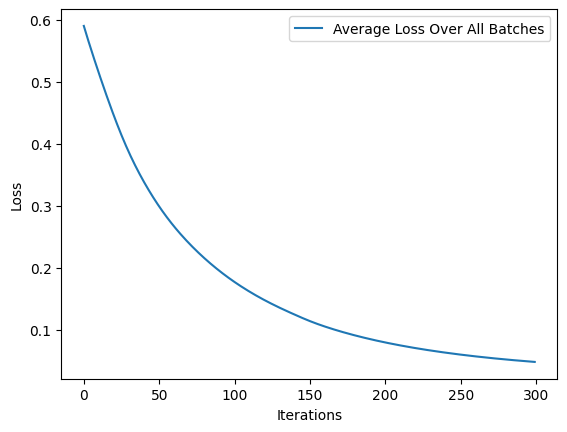

In [ ]:
# own implementation only using numpy

def sigmoid(z):
  return 1 / (1+np.exp(-z))

def get_loss(yhat, y):
    return np.mean(-y * np.log(yhat) - (1 - y) * np.log(1 - yhat))


num_itr = 300
lr = 0.001
ni = 28*28 # image resolution
nh = 50
no = 10 # num outputs (classes)

W1 = np.random.randn(nh, ni)
b1 = np.zeros((nh, 1))

W2 = np.random.randn(no, nh)
b2 = np.zeros((no, 1))

loss_history = np.zeros(num_itr)

# Get only one of the batches
x_batch, y_batch = next(iter(train_loader))

for batch_idx in range(len(x_batch)):
  x = x_batch[batch_idx].numpy()
  X = x_batch[batch_idx].numpy().reshape(ni, 1) # reshape, so that it fits the input nodes

  y = np.eye(no)[y_batch[batch_idx]].reshape(no, 1) # one hot encode y

  # Temporary list to store loss for the current batch
  temp_loss_history = []

  for i in range(num_itr):
    # Forward pass
    Z1 = W1 @ X + b1
    A1 = sigmoid(Z1)

    Z2 = W2 @ A1 + b2
    yhat = sigmoid(Z2)

    # Calculate loss and add to history
    loss = get_loss(yhat, y)
    temp_loss_history.append(loss)

    # Backward pass
    dZ2 = yhat - y
    dW2 = dZ2  @ A1.T
    db2 = np.sum(dZ2, axis=1, keepdims=True)

    dZ1 = W2.T @ (yhat - y) * A1 * (1 - A1)
    dW1 = dZ1 @ X.T
    db1 = np.sum(dZ1, axis=1, keepdims=True)

    # Optimize (Gradient Descent)
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2

  # Add the current batch loss to the overall loss history
  loss_history += np.array(temp_loss_history).flatten()


# Average the loss history over all batches
loss_history /= len(x_batch)

# Plot the average loss over iterations
plt.plot(loss_history, label="Average Loss Over All Batches")

# Display plot with labels
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Evaluation code for my handmade numpy NN

def evaluate_model(W1, b1, W2, b2, test_loader):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for x_batch, y_batch in test_loader:
        for i in range(len(x_batch)):
            x = x_batch[i].numpy().reshape(ni, 1)
            y = np.eye(no)[y_batch[i]].reshape(no, 1)

            # Forward pass
            Z1 = W1 @ x + b1
            A1 = sigmoid(Z1)

            Z2 = W2 @ A1 + b2
            yhat = sigmoid(Z2)

            # Calculate loss
            loss = get_loss(yhat, y)
            total_loss += loss

            # Get the predicted class (the index of the max output)
            predicted_class = np.argmax(yhat)
            true_class = np.argmax(y)

            if predicted_class == true_class:
                correct_predictions += 1
            total_samples += 1

    # Average loss over all test samples
    average_loss = total_loss / total_samples

    # Accuracy
    accuracy = correct_predictions / total_samples

    return average_loss, accuracy

# Evaluate the model on the test set
average_loss, accuracy = evaluate_model(W1, b1, W2, b2, test_loader)

print(f"Test Loss: {average_loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Loss: 0.4496135401963512
Test Accuracy: 27.02%


# Conclusion

It can be done by hand and is reasonably fast due to @ calculations. But with only one batch of training data and 300 iterations it is not well suited to predict never before seen data. (~25% accurate, depending on the run)

# Solved with pytorch NN implementation

In [ ]:
# Implementation of my own NN using pytorch (object oriented way)

class MNIST_Shirt_NN(nn.Module):
  def __init__(self, ni, h1, h2, no):
    super(MNIST_Shirt_NN, self).__init__()
    self.layer_one = nn.Linear(ni, h1)
    self.layer_two = nn.Linear(h1, h2)
    self.layer_three = nn.Linear(h2, no)

    self.hidden_activation = nn.ReLU()

  def forward(self, x):
    z1 = self.layer_one(x)
    a1 = self.hidden_activation(z1)

    z2 = self.layer_two(a1)
    a2 = self.hidden_activation(z2)

    z3 = self.layer_three(a2)
    # omiting a3, since the backward function will take care of it

    return z3

In [ ]:
 # Setting up the model with its params

lr = 0.00021
model = MNIST_Shirt_NN(28*28, 64, 32, 10)

optimizer = Adam(model.parameters(), lr=lr )
loss_func = nn.CrossEntropyLoss()

model.to(device)

MNIST_Shirt_NN(
  (layer_one): Linear(in_features=784, out_features=64, bias=True)
  (layer_two): Linear(in_features=64, out_features=32, bias=True)
  (layer_three): Linear(in_features=32, out_features=10, bias=True)
  (hidden_activation): ReLU()
)

In [ ]:
# Check model parameters (2,689 in total)

summary(model, (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]          50,240
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 32]           2,080
              ReLU-4                   [-1, 32]               0
            Linear-5                   [-1, 10]             330
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


In [ ]:

# Assess model without prior training

"""
model.eval() # sets model to evaluate mode
correctly_labeled = 0
val_losses = []

with torch.no_grad(): # disables caluclation of gradient descent (more memory efficient)
  val_epoch_weighted_loss = 0

  # val_batch_X and *_y represent one of the batches
  for val_batch_X, val_batch_y in test_loader:
    val_batch_X = val_batch_X.view(-1, 28*28).to(device) # reshape (from (1 (gray-scale), 28, 28) => (748))  and send to device

    # send y's to device
    val_batch_y = val_batch_y.to(device)

    # run model and get yhat (model prediction (tensors with probabilities for every batch entry), but not turned into classes yet)
    val_batch_yhat = model(val_batch_X)

    # save loss between predicted and actual y
    loss = loss_func(val_batch_yhat, val_batch_y)

    # ???
    val_epoch_weighted_loss += (len(val_batch_y) * loss.item())

    # yhat but assigned a class (the one with highest probability for given batch entry)
    val_batch_pred = val_batch_yhat.argmax(dim=1)

    correctly_labeled += (val_batch_pred == val_batch_y).sum().item()

val_epoch_loss = val_epoch_weighted_loss / len(test_loader.dataset)
val_losses.append(val_epoch_loss)

print(f'val_loss={val_epoch_loss}. labelled {correctly_labeled}/{len(test_loader.dataset)} correctly ({correctly_labeled/len(test_loader.dataset)*100}% accuracy)')

"""

"\nmodel.eval() # sets model to evaluate mode\ncorrectly_labeled = 0\nval_losses = []\n\nwith torch.no_grad(): # disables caluclation of gradient descent (more memory efficient)\n  val_epoch_weighted_loss = 0\n\n  # val_batch_X and *_y represent one of the batches\n  for val_batch_X, val_batch_y in test_loader:\n    val_batch_X = val_batch_X.view(-1, 28*28).to(device) # reshape (from (1 (gray-scale), 28, 28) => (748))  and send to device\n\n    # send y's to device\n    val_batch_y = val_batch_y.to(device)\n\n    # run model and get yhat (model prediction (tensors with probabilities for every batch entry), but not turned into classes yet)\n    val_batch_yhat = model(val_batch_X)\n\n    # save loss between predicted and actual y\n    loss = loss_func(val_batch_yhat, val_batch_y)\n\n    # ???\n    val_epoch_weighted_loss += (len(val_batch_y) * loss.item())\n\n    # yhat but assigned a class (the one with highest probability for given batch entry)\n    val_batch_pred = val_batch_yhat.argm

In [ ]:
%%time
# %% time is a magic function (from ipython) to print CPU and wall time

# Training setup and evaluation (alternating)

# Amount of full dataset passes
num_epochs = 10


train_losses = []
val_losses = []


for epoch_no in range(num_epochs):
  model.train()  # set model to train mode
  epoch_weighted_loss = 0

  for batch_X, batch_y in train_loader:
    batch_X = batch_X.view(-1, 28*28).to(device)  # convert to [N, 28*28] shape where N is batch_size
    batch_y = batch_y.to(device)

    batch_yhat = model(batch_X)  # outputs [N, 10] where each [:, 10] is probabilities for class (0-9)

    loss = loss_func(batch_yhat, batch_y)

    optimizer.zero_grad()  # need ot clear gradiens from the before batch, since the buffers are set up to be addable
    loss.backward()  # calculate new gradients (this does not need to be implemented by us. PyTorch takes care of it)
    optimizer.step()  # update weights (influenced by amount of learning rate)

    epoch_weighted_loss += (len(batch_y)*loss.item())

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
  train_losses.append(epoch_loss)    # add loss for tracking. one entry per epoch


  # validation time

  model.eval()  # turn model to evaluation mode.
  correctly_labelled = 0

  with torch.no_grad():  # this makes our model to NOT track gradients

    val_epoch_weighted_loss = 0

    # notice that we use test data to evaluate
    for val_batch_X, val_batch_y in test_loader:

      val_batch_X = val_batch_X.view(-1, 28*28).to(device) #reshape to fit for matrix math
      val_batch_y = val_batch_y.to(device) # send to device

      batch_yhat = model(val_batch_X)

      loss = loss_func(batch_yhat, val_batch_y)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = batch_yhat.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob

      correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list

  val_epoch_loss = val_epoch_weighted_loss/len(test_loader.dataset)
  val_losses.append(val_epoch_loss)
  print(f"Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)")

print(f"Training complete on device {device}.")

Epoch: 0, train_loss=0.8714491146087646, val_loss=0.5929355233669281. labelled 7908/10000 correctly (79.08% accuracy)
Epoch: 1, train_loss=0.5238681130409241, val_loss=0.5126147129058838. labelled 8198/10000 correctly (81.98% accuracy)
Epoch: 2, train_loss=0.46556881267229716, val_loss=0.4772445140838623. labelled 8324/10000 correctly (83.24000000000001% accuracy)
Epoch: 3, train_loss=0.4338389228026072, val_loss=0.455976832485199. labelled 8415/10000 correctly (84.15% accuracy)
Epoch: 4, train_loss=0.4136542116800944, val_loss=0.4413072949409485. labelled 8448/10000 correctly (84.48% accuracy)
Epoch: 5, train_loss=0.39911548242568967, val_loss=0.43118486256599425. labelled 8478/10000 correctly (84.78% accuracy)
Epoch: 6, train_loss=0.38760969244639076, val_loss=0.4225602210044861. labelled 8497/10000 correctly (84.97% accuracy)
Epoch: 7, train_loss=0.3781280177752177, val_loss=0.4164277677059174. labelled 8515/10000 correctly (85.15% accuracy)
Epoch: 8, train_loss=0.3702041662851969, 

In [ ]:
# Plot validation vs test loss

fig = go.Figure()

# Add traces for train and validation losses
fig.add_trace(go.Scatter(x=list(range(len(train_losses))), y=train_losses, mode='lines+markers', name='train loss'))
fig.add_trace(go.Scatter(x=list(range(len(val_losses))), y=val_losses, mode='lines+markers', name='val loss'))

# Update layout
fig.update_layout(
    title='Training and Validation Loss',
    xaxis_title='Epoch',
    yaxis_title='Loss (Cross Entropy)',
    legend_title='Loss Type'
)

# Show plot
fig.show()


In [ ]:
# Visualize how sum of the losses evolve

# Compute the difference (validation loss - training loss)
loss_diff = np.array(val_losses) - np.array(train_losses)

# Create an array for epochs
xs = np.arange(num_epochs)

# Create the figure
fig = go.Figure()

# Add a trace for the difference between validation and training losses
fig.add_trace(go.Scatter(x=xs, y=loss_diff, mode='lines+markers', name='Validation - Train Loss'))

# Update layout
fig.update_layout(
    title='Difference Between Validation and Training Loss Over Time',
    xaxis_title='Epoch',
    yaxis_title='Difference (Validation Loss - Train Loss)',
)

# Show plot
fig.show()

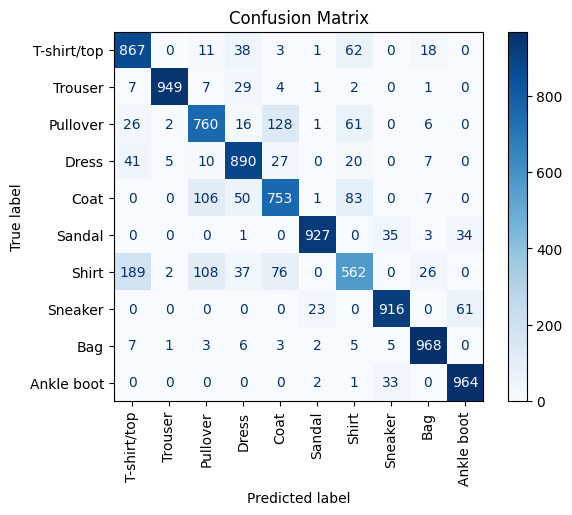

In [ ]:
# One more evaluation pass with trained model before creating a confusion matrix

import numpy as np
import matplotlib.pyplot as plt

# Collect predictions and true labels
all_preds = []
all_labels = []

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient tracking
    for val_batch_X, val_batch_y in test_loader:
        val_batch_X = val_batch_X.view(-1, 28*28).to(device)
        val_batch_y = val_batch_y.to(device)

        batch_yhat = model(val_batch_X)
        val_batch_y_pred = batch_yhat.argmax(dim=1)  # Get predicted labels

        all_preds.extend(val_batch_y_pred.cpu().numpy())
        all_labels.extend(val_batch_y.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()


# Conslusion
From the confusion matrix one can see which items the model struggles with the most. For now it seems to be shirt / t-shirt and pullover / coat.

The diagonal shows the amount of correctly predicted items.

In [ ]:
# Evaluation and Classification Report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)

        # Forward pass
        output = model(data)

        # Convert output to predicted class labels
        preds = torch.argmax(output, dim=1)

        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy()) # better compatibility from pytorch tensor
        all_labels.extend(target.cpu().numpy())

# Generate the classification report
report = classification_report(all_labels, all_preds, target_names=train_data.classes)
print(report)

              precision    recall  f1-score   support

 T-shirt/top       0.76      0.87      0.81      1000
     Trouser       0.99      0.95      0.97      1000
    Pullover       0.76      0.76      0.76      1000
       Dress       0.83      0.89      0.86      1000
        Coat       0.76      0.75      0.76      1000
      Sandal       0.97      0.93      0.95      1000
       Shirt       0.71      0.56      0.63      1000
     Sneaker       0.93      0.92      0.92      1000
         Bag       0.93      0.97      0.95      1000
  Ankle boot       0.91      0.96      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.85      0.86      0.85     10000
weighted avg       0.85      0.86      0.85     10000



# Conslusion
The model is trained well with around 86% accuracy.

From the f1 score you can see, how good the model is in recognizing the individual item.

In [ ]:
# Save model

# Get the current time and format it as a string
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Constructing filename with timestamp
filename = f"MNIST_fashion_classifier_{timestamp}.pt"

# Save the model state dictionary with the timestamped filename
torch.save(model.state_dict(), filename)

# Solved with CNN implemented in pytorch

In [ ]:
class MyCNN(nn.Module):
  def __init__(self):
    super(MyCNN, self).__init__()
    # (
    #   1 = channels (since mnist is grayscale, only one channel is needed)
    #   64 = out_channels (aka features to learn)
    #   3 = kernel / filter size (feature of this size (3x3))
    #   1  = stride of 1 (skipping one pixel per shift)
    #   1 = padding of 1 (around the image we add one pixel)
    # )
    self.conv1 = nn.Conv2d(1, 64, 3, 1, 1)
    self.conv2 = nn.Conv2d(64, 128, 3, 1, 1)
    self.linear1 = nn.Linear(7*7*128, 128)
    self.linear2 = nn.Linear(128, 10)

  def forward(self, x):
    # pass through conv layer

    # x => (batch_size, 1 channel, 28, 28(image size))
    x = self.conv1(x)
    x = torch.relu(x)
    x = max_pool2d(x, (2,2))
    # x => (batch_size, 1, 14, 14 (since max_pool reduces dimensions))

    x = self.conv2(x)
    x = torch.relu(x)
    x = max_pool2d(x, (2,2))
    # x => (batch_size, 1, 7, 7)


    # Since we now pass it to the NN, we create a vector out of it (therefore use view)
    # Always set it to -1 and not to batch_size. This could lead to different dimensions,
    #    when dataset is not created in a way, that all batches are full. e.g. last batch is not 64 but 59
    #     with -1 it auto adjusts itself for the given batch (e.g. 64 and then 59 for last batch)
    x = x.view(-1, 7*7*128)
    # x => (-1, 7(final_img_res)*7(final_img_res)*50(output_channels of last conv))


    # pass through linear layers
    x = self.linear1(x)
    x = torch.relu(x)

    x = self.linear2(x)

    # once again no softmax call here, since backward pass takes care of it
    #   meaning it is included in the loss function
    return x


Epoch: 0, train_loss=0.7479538019178008, val_loss=0.5147239729097695. labelled 8006/10000 correctly (80.06% accuracy)
Epoch: 1, train_loss=0.44943765804505525, val_loss=0.4212448531465166. labelled 8460/10000 correctly (84.6% accuracy)
Epoch: 2, train_loss=0.3800379372298272, val_loss=0.37726171931643393. labelled 8635/10000 correctly (86.35000000000001% accuracy)
Epoch: 3, train_loss=0.3418493904610708, val_loss=0.3484333230621496. labelled 8755/10000 correctly (87.55% accuracy)
Epoch: 4, train_loss=0.3147566697084153, val_loss=0.33029345361290463. labelled 8824/10000 correctly (88.24% accuracy)
Epoch: 5, train_loss=0.2936303903733399, val_loss=0.3124168897225599. labelled 8872/10000 correctly (88.72% accuracy)
Epoch: 6, train_loss=0.2764638308892891, val_loss=0.30174431081410424. labelled 8920/10000 correctly (89.2% accuracy)
Epoch: 7, train_loss=0.262149718434032, val_loss=0.29321207822697937. labelled 8952/10000 correctly (89.52% accuracy)
Epoch: 8, train_loss=0.24992688735718407, 

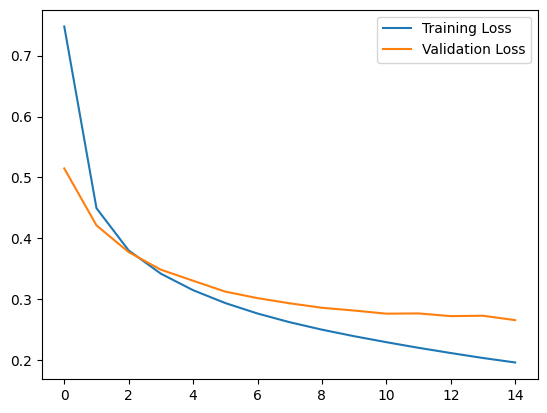

In [ ]:
# New version of train / eval

num_epochs = 15
lr = 0.01
momentum = 0.7

net = MyCNN().to(device)  # Move model to the specified device (GPU/CPU)
opt = SGD(net.parameters(), lr=lr, momentum=momentum)
#lr = 0.008
#opt = Adam(net.parameters(), lr=lr)

train_losses = []
val_losses = []

for epoch_no in range(num_epochs):
    net.train()  # Set model to training mode
    total_train_loss = 0

    for batch in train_loader:
        X, y = batch[0].to(device), batch[1].to(device)
        yhat = net(X)  # Forward pass

        loss = cross_entropy(yhat, y)
        opt.zero_grad()  # Reset gradients
        loss.backward()  # Backward pass
        opt.step()  # Update weights

        total_train_loss += loss.item()

    epoch_train_loss = total_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation phase
    net.eval()  # Set model to evaluation mode
    total_val_loss = 0
    correctly_labelled = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for val_batch in test_loader:
            val_X, val_y = val_batch[0].to(device), val_batch[1].to(device)
            val_yhat = net(val_X)  # Forward pass

            val_loss = cross_entropy(val_yhat, val_y)
            total_val_loss += val_loss.item()

            val_batch_y_pred = val_yhat.argmax(dim=1)  # Get predicted labels
            correctly_labelled += (val_batch_y_pred == val_y).sum().item()  # Count correct predictions

    epoch_val_loss = total_val_loss / len(test_loader)
    val_losses.append(epoch_val_loss)

    accuracy = correctly_labelled / len(test_loader.dataset) * 100
    print(f"Epoch: {epoch_no}, train_loss={epoch_train_loss}, val_loss={epoch_val_loss}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({accuracy}% accuracy)")

print(f"Training complete on device {device}.")

# Plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluation and Classification Report

net.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = net(data)

        # Convert output to predicted class labels
        preds = torch.argmax(output, dim=1)

        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy()) # better compatibility from pytorch tensor
        all_labels.extend(target.cpu().numpy())

# Generate the classification report
report = classification_report(all_labels, all_preds, target_names=train_data.classes)
print(report)

              precision    recall  f1-score   support

 T-shirt/top       0.78      0.92      0.85      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.83      0.88      0.85      1000
       Dress       0.87      0.95      0.91      1000
        Coat       0.86      0.83      0.85      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.85      0.60      0.71      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.90     10000
weighted avg       0.91      0.91      0.90     10000



# Using Resnet to predict items

Epoch: 0, train_loss=1.1087292965219269, val_loss=0.6460094039986848. labelled 7624/10000 correctly (76.24% accuracy)
Epoch: 1, train_loss=0.5536603517631584, val_loss=0.5544346048953427. labelled 7846/10000 correctly (78.46% accuracy)
Epoch: 2, train_loss=0.5071239795698809, val_loss=0.6740338210087673. labelled 7535/10000 correctly (75.35% accuracy)
Epoch: 3, train_loss=0.6413525853429304, val_loss=0.581763756123318. labelled 7896/10000 correctly (78.96% accuracy)
Epoch: 4, train_loss=0.5249916039160756, val_loss=0.44596424062920226. labelled 8321/10000 correctly (83.21% accuracy)
Epoch: 5, train_loss=0.39735525469578953, val_loss=0.40828068962522374. labelled 8465/10000 correctly (84.65% accuracy)
Epoch: 6, train_loss=0.38851362101041903, val_loss=0.375811487151559. labelled 8597/10000 correctly (85.97% accuracy)
Epoch: 7, train_loss=0.3438341654479313, val_loss=0.352829788710661. labelled 8690/10000 correctly (86.90% accuracy)
Epoch: 8, train_loss=0.33170495121049015, val_loss=0.33

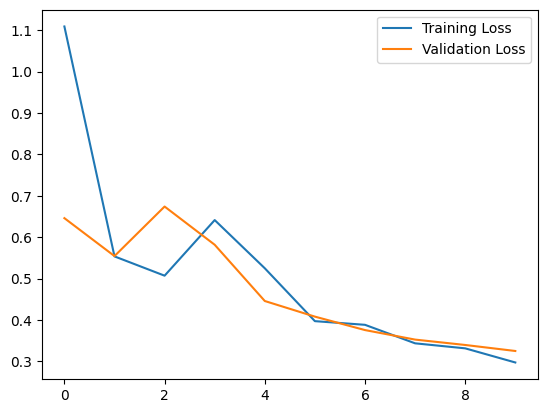

In [ ]:
# Training Resnet model and evalute it

from torchvision.models import resnet18

# Define hyperparameters
num_epochs = 10
lr = 0.05
momentum = 0.9

# Load ResNet18 model pre-trained on ImageNet
net = resnet18(pretrained=True)#.requires_grad_(False)

net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Modify the final fully connected layer to match the number of classes (e.g., 10 classes)
net.fc = nn.Linear(net.fc.in_features, 10)
net = net.to(device)  # Move the model to the specified device

# Set up optimizer and loss function
opt = SGD(net.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

# Initialize lists to store losses
train_losses = []
val_losses = []

# Training and validation loop
for epoch_no in range(num_epochs):
    net.train()  # Set model to training mode
    total_train_loss = 0

    for batch in train_loader:
        X, y = batch[0].to(device), batch[1].to(device)  # Move data to the device

        # Replicate the single grayscale channel 3 times to match the expected input format
        #X = X.repeat(1, 3, 1, 1)  # [batch_size, 1, height, width] -> [batch_size, 3, height, width]

        yhat = net(X)  # Forward pass

        loss = criterion(yhat, y)
        opt.zero_grad()  # Reset gradients
        loss.backward()  # Backward pass
        opt.step()  # Update weights

        total_train_loss += loss.item()

    epoch_train_loss = total_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)


    # Validation phase
    net.eval()  # Set model to evaluation mode
    total_val_loss = 0
    correctly_labelled = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for val_batch in test_loader:
            val_X, val_y = val_batch[0].to(device), val_batch[1].to(device)  # Move data to the device

            # Replicate the single grayscale channel 3 times to match the expected input format
            #val_X = val_X.repeat(1, 3, 1, 1)  # [batch_size, 1, height, width] -> [batch_size, 3, height, width]

            val_yhat = net(val_X)  # Forward pass

            val_loss = criterion(val_yhat, val_y)
            total_val_loss += val_loss.item()

            val_batch_y_pred = val_yhat.argmax(dim=1)  # Get predicted labels
            correctly_labelled += (val_batch_y_pred == val_y).sum().item()  # Count correct predictions

    epoch_val_loss = total_val_loss / len(test_loader)
    val_losses.append(epoch_val_loss)

    accuracy = correctly_labelled / len(test_loader.dataset) * 100
    print(f"Epoch: {epoch_no}, train_loss={epoch_train_loss}, val_loss={epoch_val_loss}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({accuracy:.2f}% accuracy)")

print(f"Training complete on device {device}.")

# Plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()


# Conclusion

Even so resnet is a very powerful model, it is most often used for images of bigger sizes and complex feature detection. Providing only 28x28 images with one grayscale channel one could conclude that this dataset is not the right fit for the model